In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, add, Flatten, Dense, DepthwiseConv2D


def PEPXModel(input_tensor, filters, name):
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'FP')(input_tensor)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Expansion')(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same', name=name + 'DWConv3_3')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'SP')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Extension')(x)
    return x


def keras_model_build(input_size=(240,240, 3)):
    # input
    input = Input(shape=input_size, name='input')
    x = Conv2D(input_shape=input_size, filters=48, kernel_size=(7, 7), activation='relu', padding='same',
               strides=(1, 1))(input)
    x = MaxPool2D(pool_size=(2, 2))(x)
    # _Conv1x1
    x =Conv2D(filters=160, kernel_size=(1,1), activation= 'relu' ,name = "conv1x1160") (x) 
    # pepx1 
    pepx_11 = PEPXModel(x, 160, "pepx1.1")
    pexp_12 = PEPXModel(add([x,pepx_11]),160, "pepx1.2")
    pexp_13 = PEPXModel(add([x,pepx_11,pexp_12]),160, "pepx1.3")
    #conv1x1
    x = Conv2D(328,kernel_size=(1,1),strides=2, activation = "relu", name = "conv1x1328") (add([x,pepx_11,pexp_12,pexp_13]))
    #pepx2
    pepx_21 = PEPXModel(x, 328, "pepx21")
    pepx_22 = PEPXModel(add([x,pepx_21]), 328, "pepx22")
    pepx_23 = PEPXModel(add([x,pepx_21,pepx_22]), 328, "pepx23")
    pepx_24 = PEPXModel(add([x,pepx_21,pepx_22,pepx_23]), 328, "pepx24")
    #conv1x1 
    x = Conv2D(640,kernel_size=(1,1),strides=2, activation = "relu", name = "conv1x140") (add([x,pepx_21,pepx_22,pepx_23,pepx_24]))
    #pepx3
    pepx_31 = PEPXModel(x,640,'pepx31')
    pepx_32 = PEPXModel(add([x,pepx_31]),640,'pepx32')
    pepx_33 = PEPXModel(add([x,pepx_31,pepx_32]),640,'pepx33')
    pepx_34 = PEPXModel(add([x,pepx_31,pepx_32,pepx_33]),640,'pepx34')
    pepx_35 = PEPXModel(add([x,pepx_31,pepx_32,pepx_33,pepx_34]),640,'pepx35')
    pepx_36 = PEPXModel(add([x,pepx_31,pepx_32,pepx_33,pepx_34,pepx_35]),640,'pepx36')
    #conv1x1 
    x = Conv2D(2048,kernel_size=(1,1),strides=2, activation = "relu", name = "conv1x12048") (add([x,pepx_31,pepx_32,pepx_33,pepx_34, pepx_35,pepx_36]))
    #pepx4
    pepx_41 = PEPXModel(x,2048,'pepx41')
    pepx_42 = PEPXModel(add([x,pepx_41]),2048,'pepx42')
    pepx_43 = PEPXModel(add([x,pepx_41,pepx_42]),2048,'pepx43')
    # FC
    fla = Flatten()(add([x,pepx_41,pepx_42,pepx_43]))
    d1 = Dense(128, activation='relu')(fla)
    d1 = Dense(56, activation='relu')(d1)
    output = Dense(3, activation='softmax')(d1)
    return keras.models.Model(input, output)

model = keras_model_build()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 240, 240, 48  7104        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 120, 120, 48  0          ['conv2d_3[0][0]']               
                                )                                                           

In [2]:
import numpy as np
import tensorflow as tf


src = "drive/MyDrive/"
x = np.load(src+"Fold-2/data-train-x-2.npy")
y = np.load(src+"Fold-2/data-train-y-2.npy")



In [ ]:
import numpy as np
import tensorflow as tf
import time
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
file_path = "drive/MyDrive/modelcnn/modelfold2.h5"

model = keras_model_build()
# model.summary()
opt = Adam(0.0001)
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
histori = model.fit(x, y, batch_size=32, epochs=10, validation_split=0.2,callbacks=[checkpoint])

In [5]:
import numpy as np
import tensorflow as tf

src = "drive/MyDrive/"
xt = np.load(src+"Fold-2/data-test-x-2.npy")
yt = np.load(src+"Fold-2/data-test-y-2.npy")


In [6]:
import matplotlib.pyplot as plt
def conf_mat(conf_arr, title):
    norm_conf = []
    for i in conf_arr:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize=(8,8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.set_title(title)
    ax.set_xlabel("Prediksi Class")
    ax.set_ylabel("Target Class")
    res = ax.imshow(np.array(norm_conf), cmap="Paired", 
                    interpolation='nearest')

    width, height = conf_arr.shape
    textcolors = ["w", "k"]
    for x in range(width):
        for y in range(height):
            ax.text(y, x, str(conf_arr[x][y]),
                    ha="center", va="center",
                    color=textcolors[0.2 < norm_conf[x][y] < 0.9],
                    fontsize=13,
                    weight='bold')

In [ ]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import Sequential, Model, load_model
import time
mod_path2 = "drive/MyDrive/modelcnn/"

LABEL_NAMES = ["COVID","Normal","Pneumonia"]

target_test = np.argmax(yt,axis=1)

mod = load_model(mod_path2+"modelfold2.h5")
awal = time.time()
model = mod.predict(xt)
y_pred = np.argmax(model, axis=1)

print("Hasil K-Fold-2")

cls_report = classification_report(target_test, y_pred, target_names=LABEL_NAMES)

print (cls_report)

acc_score = accuracy_score(target_test, y_pred)
print (acc_score)

cm = confusion_matrix(target_test, y_pred)



print("F1-skor Keseluruhan")

precision = precision_score(target_test, y_pred, average='macro')
recall = recall_score(target_test, y_pred, average='macro')
f1_score = 2 * precision * recall / (precision + recall)

print("Precision = ", precision)
print("Recall = ", recall)
print("F1 Score = ", f1_score)
ahir = time.time()
waktu_testing = ahir-awal
print("waktu testing =",waktu_testing,"detik")

In [ ]:
import matplotlib.pyplot as plt
jumlah = 0
for image, prediction, label in zip(xt, y_pred, target_test ):
  if prediction != label:
    print('has been classified as ',LABEL_NAMES[prediction], 'and should be ', LABEL_NAMES[label])
    jumlah+=1
print(jumlah) 

has been classified as  Pneumonia and should be  COVID
has been classified as  Pneumonia and should be  COVID
has been classified as  Pneumonia and should be  COVID
has been classified as  Pneumonia and should be  COVID
has been classified as  Pneumonia and should be  COVID
has been classified as  Pneumonia and should be  COVID
has been classified as  Pneumonia and should be  COVID
has been classified as  Pneumonia and should be  COVID
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  Pneumonia and should be  Normal
has been classified as  COVID and sh

NameError: ignored

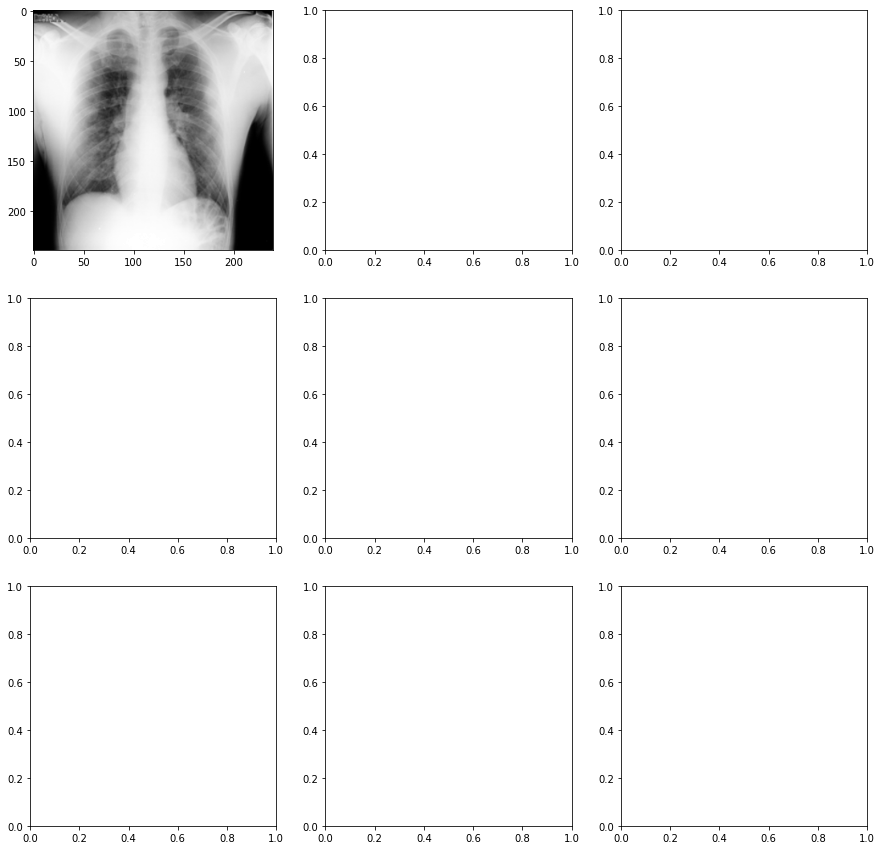

In [ ]:
fig , axes = plt.subplots(3,3,figsize=(15,15))
for image, prediction,label, ax in zip(xt,y_pred,target_test,axes.flatten()):    
  font = {"color":'r'} 
  if prediction != label :
    l = LABEL_NAMES[label]
    p = LABEL_NAMES[prediction]
  axes.imshow(image)
  axes.set_title(f"L: {l} | p:{p} ", fontdict=font);
  axes.axis('off')

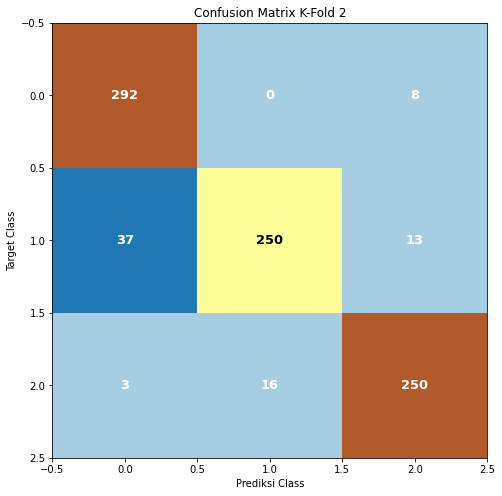

In [ ]:
conf_mat(cm, "Confusion Matrix K-Fold 2" )

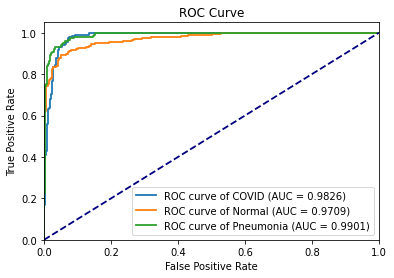

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

def show_roc_curve(y_test_cat, y_pred_prob, target, title):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:,i], y_pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  linewidth = 1.8
  plt.figure()
  plt.title(title)
  for i in range(3):
      plt.plot(fpr[i], tpr[i], lw=linewidth, label='ROC curve of %s (AUC = %0.4f)' % (target[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

show_roc_curve(yt, model, LABEL_NAMES, 'ROC Curve')

0.9824633422541683

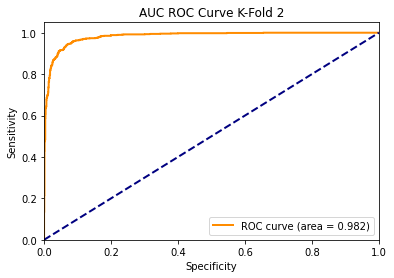

In [ ]:
def create_auc_roc(y_test_cat, y_pred_cat, title):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], model[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_cat.ravel(), model.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
            lw=lw, label='ROC curve (area = %0.3f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title(title)
    plt.legend(loc="lower right")
    
    return roc_auc["micro"]
create_auc_roc(yt, model, "AUC ROC Curve K-Fold 2" )


*testing* full

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf

src = "drive/MyDrive/"
xtest_full = []
ytest_full = []

for kfld in range(1,6):
  xt = np.load(src+"Fold-%s/data-test-x-%s.npy"%(kfld,kfld))
  yt = np.load(src+"Fold-%s/data-test-y-%s.npy"%(kfld,kfld))
  xtest_full.append(xt)
  ytest_full.append(yt)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

def show_roc_curve(y_test_cat, y_pred_prob, target, title):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:,i], y_pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  linewidth = 1.8
  plt.figure()
  plt.title(title)
  for i in range(3):
      plt.plot(fpr[i], tpr[i], lw=linewidth, label='ROC curve of %s (AUC = %0.4f)' % (target[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()


In [ ]:
def create_auc_roc(y_test_cat, y_pred_cat, title):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], model[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_cat.ravel(), model.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
            lw=lw, label='ROC curve (area = %0.3f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title(title)
    plt.legend(loc="lower right")
    
    return roc_auc["micro"]

In [ ]:
import matplotlib.pyplot as plt
def conf_mat(conf_arr, title):
    norm_conf = []
    for i in conf_arr:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize=(8,8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.set_title(title)
    ax.set_xlabel("Prediksi Class")
    ax.set_ylabel("Target Class")
    res = ax.imshow(np.array(norm_conf), cmap="Paired", 
                    interpolation='nearest')

    width, height = conf_arr.shape
    textcolors = ["w", "k"]
    for x in range(width):
        for y in range(height):
            ax.text(y, x, str(conf_arr[x][y]),
                    ha="center", va="center",
                    color=textcolors[0.2 < norm_conf[x][y] < 0.9],
                    fontsize=13,
                    weight='bold')

Hasil K-Fold-1
              precision    recall  f1-score   support

       COVID       0.91      0.99      0.95       300
      Normal       1.00      0.89      0.94       300
   Pneumonia       0.97      1.00      0.99       269

    accuracy                           0.96       869
   macro avg       0.96      0.96      0.96       869
weighted avg       0.96      0.96      0.96       869

0.9585730724971231
F1-skor Keseluruhan
Precision =  0.9618935419815654
Recall =  0.96
F1 Score =  0.9609458381864526


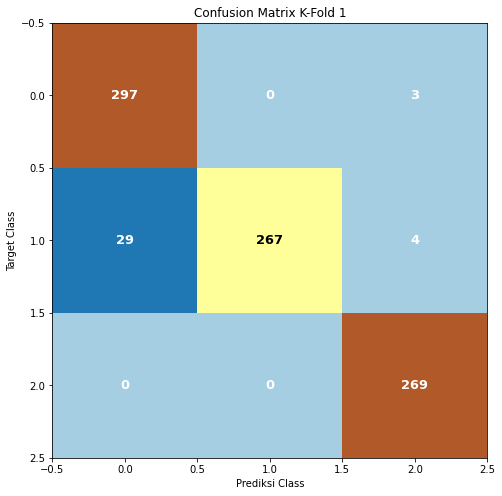

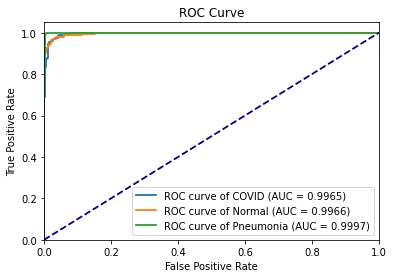

Hasil K-Fold-2
              precision    recall  f1-score   support

       COVID       0.88      0.97      0.92       300
      Normal       0.94      0.83      0.88       300
   Pneumonia       0.92      0.93      0.93       269

    accuracy                           0.91       869
   macro avg       0.91      0.91      0.91       869
weighted avg       0.91      0.91      0.91       869

0.9113924050632911
F1-skor Keseluruhan
Precision =  0.9139589738138526
Recall =  0.9120115654688146
F1 Score =  0.9129842311800931


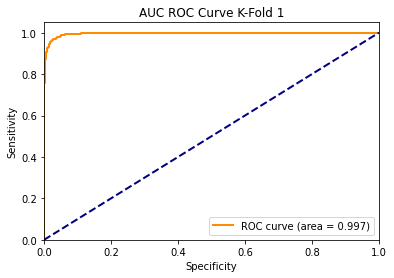

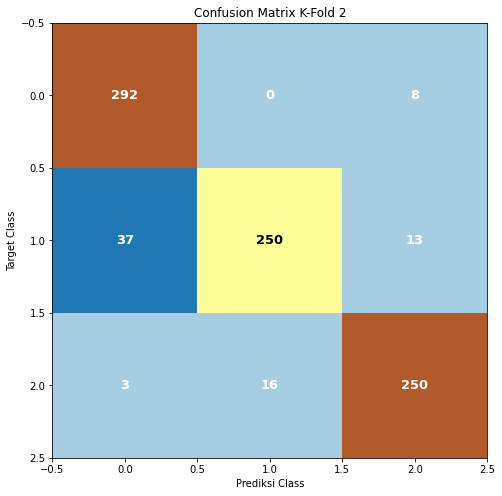

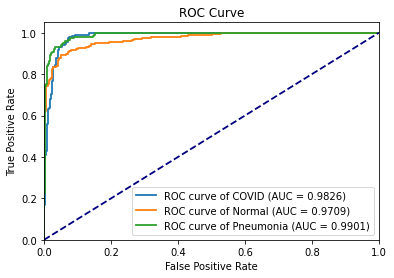

Hasil K-Fold-3
              precision    recall  f1-score   support

       COVID       0.92      0.95      0.94       300
      Normal       0.93      0.91      0.92       300
   Pneumonia       0.96      0.95      0.95       269

    accuracy                           0.94       869
   macro avg       0.94      0.94      0.94       869
weighted avg       0.94      0.94      0.94       869

0.9367088607594937
F1-skor Keseluruhan
Precision =  0.9376498342481261
Recall =  0.9370962412226352
F1 Score =  0.9373729560002482


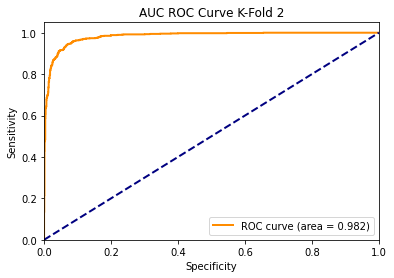

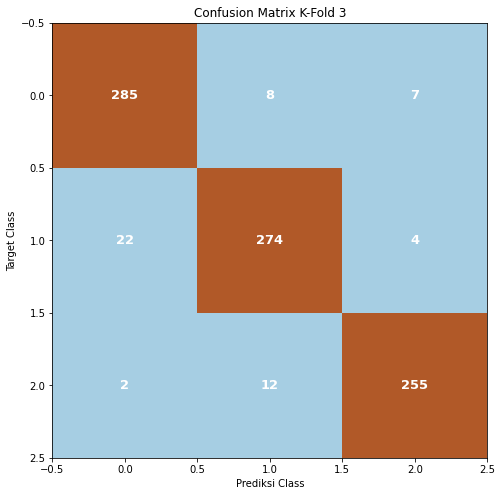

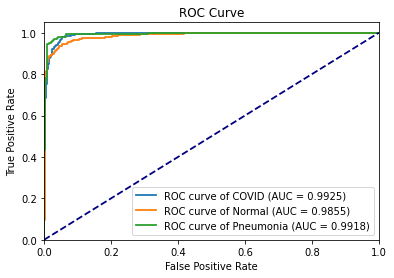

Hasil K-Fold-4
              precision    recall  f1-score   support

       COVID       0.90      0.96      0.93       300
      Normal       0.88      0.90      0.89       300
   Pneumonia       0.96      0.86      0.91       269

    accuracy                           0.91       869
   macro avg       0.91      0.91      0.91       869
weighted avg       0.91      0.91      0.91       869

0.906789413118527
F1-skor Keseluruhan
Precision =  0.9106413280399895
Recall =  0.9051342420487402
F1 Score =  0.9078794337930829


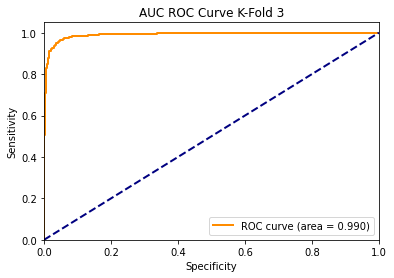

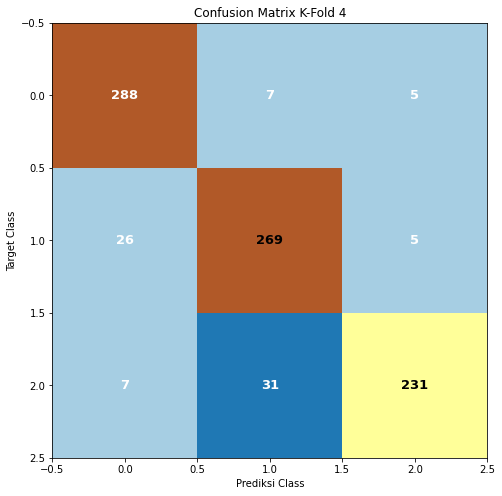

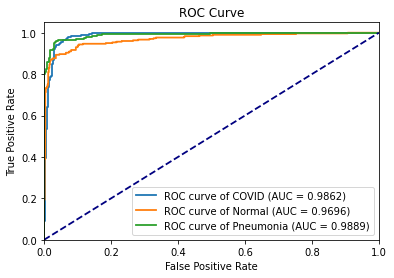

Hasil K-Fold-5
              precision    recall  f1-score   support

       COVID       0.93      0.95      0.94       300
      Normal       0.91      0.90      0.91       300
   Pneumonia       0.96      0.94      0.95       269

    accuracy                           0.93       869
   macro avg       0.93      0.93      0.93       869
weighted avg       0.93      0.93      0.93       869

0.9298043728423475
F1-skor Keseluruhan
Precision =  0.9309369132374838
Recall =  0.9301734820322182
F1 Score =  0.9305550410543477


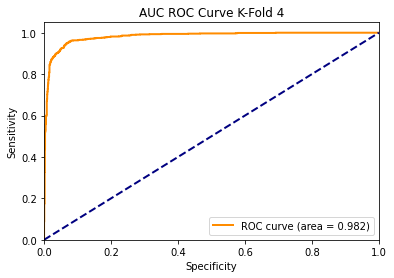

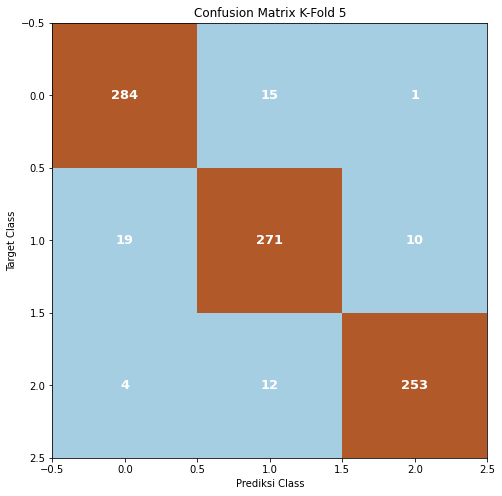

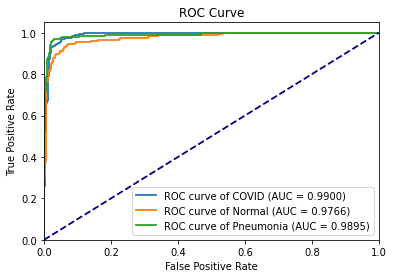

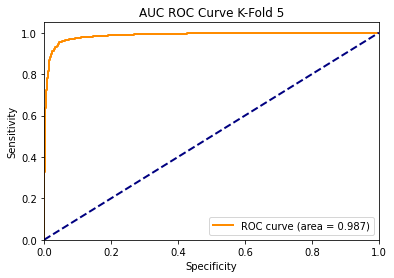

In [ ]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import Sequential, Model, load_model
mod_path2 = "drive/MyDrive/modelcnn/"

LABEL_NAMES = ["COVID","Normal","Pneumonia"]
for kfold in range(0,5):
  target_test = np.argmax(ytest_full[kfold],axis=1)

  mod = load_model(mod_path2+"modelfold%s.h5"%(kfold+1))
  model = mod.predict(xtest_full[kfold])
  y_pred = np.argmax(model, axis=1)

  print("Hasil K-Fold-%s"%(kfold+1))

  cls_report = classification_report(target_test, y_pred, target_names=LABEL_NAMES)

  print (cls_report)

  acc_score = accuracy_score(target_test, y_pred)
  print (acc_score)

  cm = confusion_matrix(target_test, y_pred)
  conf_mat(cm, "Confusion Matrix K-Fold %s"%(kfold+1) )


  print("F1-skor Keseluruhan")

  precision = precision_score(target_test, y_pred, average='macro')
  recall = recall_score(target_test, y_pred, average='macro')
  f1_score = 2 * precision * recall / (precision + recall)

  print("Precision = ", precision)
  print("Recall = ", recall)
  print("F1 Score = ", f1_score)
  show_roc_curve(ytest_full[kfold], model, LABEL_NAMES, 'ROC Curve')
  create_auc_roc(ytest_full[kfold], model, "AUC ROC Curve K-Fold %s"%(kfold+1))
  